# Caso de estidio 3: Titanic

## Descripción

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

## Data

Overview

The data has been split into two groups:

    training set (train.csv)
    test set (test.csv)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.
Data Dictionary
Variable	Definition	Key
survival 	Survival 	0 = No, 1 = Yes
pclass 	Ticket class 	1 = 1st, 2 = 2nd, 3 = 3rd
sex 	Sex 	
Age 	Age in years 	
sibsp 	# of siblings / spouses aboard the Titanic 	
parch 	# of parents / children aboard the Titanic 	
ticket 	Ticket number 	
fare 	Passenger fare 	
cabin 	Cabin number 	
embarked 	Port of Embarkation 	C = Cherbourg, Q = Queenstown, S = Southampton
Variable Notes

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [89]:
#Load Data

# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm
import sklearn.model_selection as model_selection
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")



In [90]:
#Cargar datos
trainingset=pd.read_csv('train.csv')
trainingset.head()
testset=pd.read_csv('test.csv')

In [91]:
#Describir Datos
trainingset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [92]:
print(trainingset.shape)
#Datos null 
trainingset.isnull().sum()
#Existen 177 datos de Edad los cuales se muestran como nulos,

(891, 12)


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [93]:
#Limpieza de datos
trainingset.drop("Cabin",inplace=True,axis=1)
testset.drop("Cabin",inplace=True,axis=1)
#Male=1, woman =0
#Converit a Dommy
trainingset[["Male"]]=pd.get_dummies(trainingset["Sex"],drop_first=True)
testset[["Male"]]=pd.get_dummies(testset["Sex"],drop_first=True)
#Convert a Dommy training
trainingset[['QPort','SPort']] = pd.get_dummies(trainingset["Embarked"],drop_first=True)
trainingset[['First','Second']] = pd.get_dummies(trainingset["Pclass"]).iloc[:,[0,1]]

#Convert a Dommy test
testset[['QPort','SPort']] = pd.get_dummies(testset["Embarked"],drop_first=True)
testset[['First','Second']] = pd.get_dummies(testset["Pclass"]).iloc[:,[0,1]]



In [94]:
trainingset.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Male,QPort,SPort,First,Second
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.647587,0.086420,0.722783,0.242424,0.206510
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.477990,0.281141,0.447876,0.428790,0.405028
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000,0.000000,1.000000,0.000000,0.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000


In [95]:
trainingset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Male,QPort,SPort,First,Second
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,0,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0,0,1,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,0,1,0,0


In [96]:
#Crear variable Familiar
trainingset['Family']= trainingset['SibSp']+trainingset['Parch']
trainingset['Family']=trainingset['Family'].apply(lambda x: 1 if x>0 else 0)


testset['Family']= trainingset['SibSp']+trainingset['Parch']
testset['Family']=trainingset['Family'].apply(lambda x: 1 if x>0 else 0)
trainingset.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Male,QPort,SPort,First,Second,Family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,0,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,0,0,1,0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0,0,1,1,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,0,1,0,0,0


In [97]:
#Eliminación de variables que  no interesan 
trainingset.drop(["PassengerId","Name","Ticket","Pclass","Embarked","Sex",'SibSp','Parch'],axis=1,inplace=True)
testset.drop(["PassengerId","Name","Ticket","Pclass","Embarked","Sex",'SibSp','Parch'],axis=1,inplace=True)


In [98]:
trainingset.head()

,Survived,Age,Fare,Male,QPort,SPort,First,Second,Family
0,0,22.0,7.2500,1,0,1,0,0,1
1,1,38.0,71.2833,0,0,0,1,0,1
2,1,26.0,7.9250,0,0,1,0,0,0
3,1,35.0,53.1000,0,0,1,1,0,1
4,0,35.0,8.0500,1,0,1,0,0,0


In [99]:
testset.head()

,Age,Fare,Male,QPort,SPort,First,Second,Family
0,34.5,7.8292,1,1,0,0,0,1
1,47.0,7.0000,0,0,1,0,0,1
2,62.0,9.6875,1,1,0,0,1,0
3,27.0,8.6625,1,0,1,0,0,1
4,22.0,12.2875,0,0,1,0,0,0


Existen 177 valores nulos de Edad, tenemos que agregar datos a estos valores con el fin de completar el modelo.

In [100]:
trainingset['Age2']=trainingset['Age']
trainingset['Age2'][trainingset['Age2'].isnull()]=np.abs(np.around(np.random.normal(29.699118,14.526497, 177)))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [101]:
trainingset.describe()

,Survived,Age,Fare,Male,QPort,SPort,First,Second,Family,Age2
count,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,29.699118,32.204208,0.647587,0.086420,0.722783,0.242424,0.206510,0.397306,29.662368
std,0.486592,14.526497,49.693429,0.477990,0.281141,0.447876,0.428790,0.405028,0.489615,14.500822
min,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.420000
25%,0.000000,20.125000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
50%,0.000000,28.000000,14.454200,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,28.000000
75%,1.000000,38.000000,31.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,38.000000
max,1.000000,80.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,80.000000


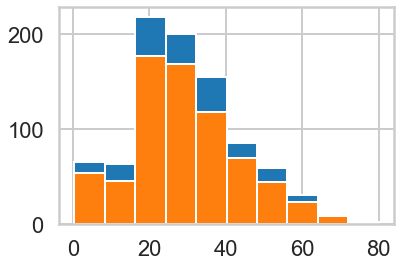

In [102]:
#Histograma Age vs age 2
trainingset['Age2'].hist()
trainingset['Age'].hist()

In [103]:
trainingset.drop(['Age'],axis=1,inplace=True)

In [104]:
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if abs(val) > 0.1956 else 'black'
    return 'color: %s' % color
corr=trainingset.corr()
corr.style.applymap(color_negative_red)

,Survived,Fare,Male,QPort,SPort,First,Second,Family,Age2
Survived,1,0.257307,-0.543351,0.00365038,-0.15566,0.285904,0.0933486,0.203367,-0.0558709
Fare,0.257307,1,-0.182333,-0.117216,-0.166603,0.591711,-0.118557,0.271832,0.0977909
Male,-0.543351,-0.182333,1,-0.0741151,0.125722,-0.0980131,-0.0647463,-0.303646,0.0573828
QPort,0.00365038,-0.117216,-0.0741151,1,-0.496624,-0.155342,-0.127301,-0.0864637,-0.00895794
SPort,-0.15566,-0.166603,0.125722,-0.496624,1,-0.170379,0.192061,-0.0249292,-0.0252268
First,0.285904,0.591711,-0.0980131,-0.155342,-0.170379,1,-0.288585,0.113364,0.301661
Second,0.0933486,-0.118557,-0.0647463,-0.127301,0.192061,-0.288585,1,0.03907,0.00496525
Family,0.203367,0.271832,-0.303646,-0.0864637,-0.0249292,0.113364,0.03907,1,-0.144854
Age2,-0.0558709,0.0977909,0.0573828,-0.00895794,-0.0252268,0.301661,0.00496525,-0.144854,1


In [105]:
y = trainingset["Survived"]
X = trainingset.drop("Survived",axis=1)
import sklearn.model_selection as model_selection

X_train, X_Val, y_train, y_Val = model_selection.train_test_split(X, y, test_size = 0.3, random_state = 20)

In [106]:
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
logmodel.score(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8057784911717496

In [107]:
X_train.drop(['Fare','QPort'],axis=1,inplace=True)
X_Val.drop(['Fare','QPort'],axis=1,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [108]:
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
logmodel.score(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7993579454253612

In [109]:
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if abs(val) > 0.1956 else 'black'
    return 'color: %s' % color
corr=X_train.corr()
corr.style.applymap(color_negative_red)

,Male,SPort,First,Second,Family,Age2
Male,1,0.164967,-0.103466,-0.0532868,-0.282728,0.0365506
SPort,0.164967,1,-0.161222,0.187418,-0.0466815,-0.0240978
First,-0.103466,-0.161222,1,-0.29933,0.107144,0.294492
Second,-0.0532868,0.187418,-0.29933,1,0.0724003,-0.0192784
Family,-0.282728,-0.0466815,0.107144,0.0724003,1,-0.113569
Age2,0.0365506,-0.0240978,0.294492,-0.0192784,-0.113569,1


In [110]:
predictions = logmodel.predict(X_Val)
from sklearn.metrics import classification_report
print(classification_report(y_Val, predictions))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       170
           1       0.68      0.70      0.69        98

    accuracy                           0.77       268
   macro avg       0.75      0.75      0.75       268
weighted avg       0.77      0.77      0.77       268



In [82]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_Val, predictions),columns={'True','False'},index={'False','True'})

,False,True
False,140,30
True,30,68


pandas.core.series.Series